In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Sloan Digital Sky Survey (SDSS) – jeden z najważniejszych przeglądów nieba w historii astronomii. Nazwa projektu jest związana z Fundacją im. Alfreda P. Sloana. Program obserwacyjny został rozpoczęty w roku 2000 i do chwili obecnej przyniósł odkrycie m.in. 930 tysięcy galaktyk oraz ponad 120 tysięcy kwazarów po przejrzeniu ponad 1/4 całego nieba. 

Dane dostępne są do pobrania w internecie - my wykorzystamy połączone 4 zestawy danych uzyskane na skutek Sloan Digital Sky Survey IV.

In [2]:
dr14 = pd.read_csv('Dataset/SDSS_DR14.csv')
dr16 = pd.read_csv('Dataset/SDSS_DR16.csv')
dr17 = pd.read_csv('Dataset/SDSS_DR17.csv')
dr18 = pd.read_csv('Dataset/SDSS_DR18.csv') 
dataframe = pd.concat([dr14, dr16, dr17, dr18], ignore_index=True, sort=False)

In [3]:
df = dataframe.dropna(axis=1, how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      310000 non-null  object 
 1   ra         310000 non-null  float64
 2   dec        310000 non-null  float64
 3   u          310000 non-null  float64
 4   g          310000 non-null  float64
 5   r          310000 non-null  float64
 6   i          310000 non-null  float64
 7   z          310000 non-null  float64
 8   run        310000 non-null  int64  
 9   rerun      310000 non-null  int64  
 10  camcol     310000 non-null  int64  
 11  field      310000 non-null  int64  
 12  specobjid  310000 non-null  object 
 13  class      310000 non-null  object 
 14  redshift   310000 non-null  float64
 15  plate      310000 non-null  int64  
 16  mjd        310000 non-null  int64  
 17  fiberid    310000 non-null  int64  
dtypes: float64(8), int64(7), object(3)
memory usage: 42.6+ MB


Usuwamy informacje,które nie są związane z kategoryzacją naszego obiektu. Są to głównie informacje techniczne na temat numeru obserwacji, numeru katalogowego itp. My będziemy korzystać z:

- u = Dane z filtra ultrafioletu
- g = Dane z filtra zielonego
- r = Dane z filtra czerwonego
- i = Dane z filtra bliskiej podczerwi (Near Infrared) 
- z = Dane z filtra podczerwieni
- redshift = przesunięcie ku czerwieni na podstawie zwiększenia długości fali

Jasności na filtrach są podawane w Asinh magnitudo. Wyraża się ono wzorem:

\begin{aligned}
\frac{-2.5}{\ln 10}  * \text{arcsinh}( \frac{\frac{f}{f_0}}{2b}  +\ln(b))
\end{aligned}

gdzie:
- b jest stałą zmiękczającą można sprawdzić pod [liniem](https://www.sdss4.org/dr17/algorithms/magnitudes/).
- f$_0$ to jasność odniesienia. Klasycznie jest to jasność gwiazdy Vega.
- f to obserwowana jasność



In [4]:
df=df.drop(columns=['objid','run','rerun','camcol','field','specobjid','plate','mjd','fiberid'])

Rzućmy okiem na dane - w wartościach minimalnych można zauważyć, że coś jest nie tak - pojawiają się ekstremalnie niskie wartości wielkości gwaizdowych.

In [5]:
df.describe()

,ra,dec,u,g,r,i,z,redshift
count,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000,310000.000000
mean,174.694084,22.097973,19.716598,18.413805,17.770995,17.382543,17.075167,0.300031
std,85.593731,22.738541,18.124083,18.109926,1.907456,18.081449,36.024479,0.579806
min,0.003092,-19.495456,-9999.000000,-9999.000000,9.005167,-9999.000000,-9999.000000,-0.009971
25%,131.354822,1.042457,18.510617,17.143935,16.472307,16.136660,15.908515,0.000107
50%,175.860912,17.145758,19.184505,17.904820,17.357705,17.063675,16.893270,0.070177
75%,223.633481,41.176901,20.162707,19.213520,18.882188,18.631750,18.436143,0.279405
max,359.999810,84.490494,32.781390,31.602240,31.990100,32.141470,29.383740,7.011245


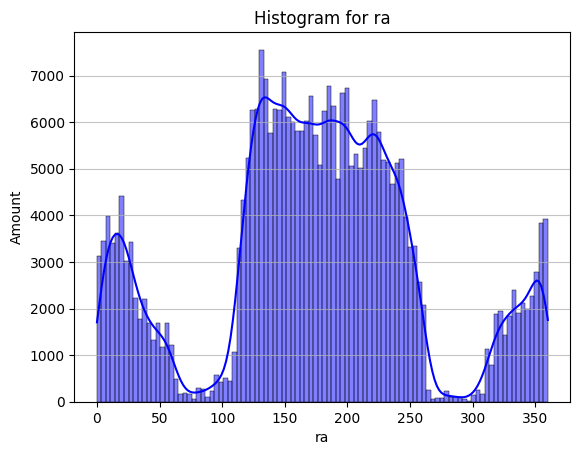

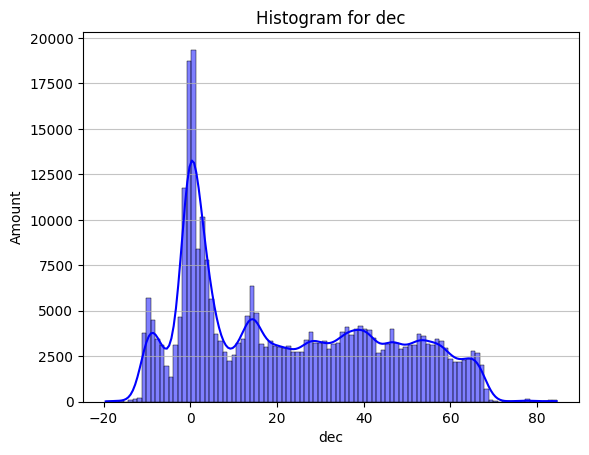

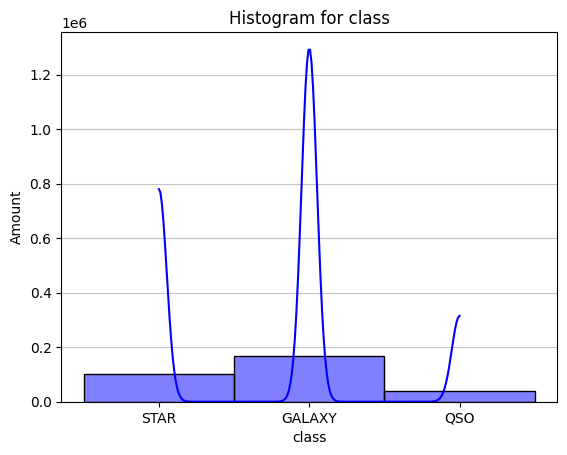

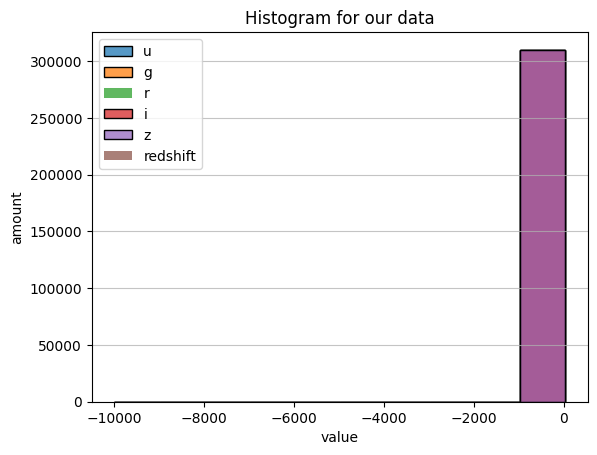

In [6]:
for column in ['ra','dec','class']:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(df[column], kde=True, bins=100, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Amount')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plt.figure()  # Create a new figure for each histogram
for column in df.select_dtypes(include=['number']).columns: 
    if column != 'ra'and column!='dec' and column != 'class':
        sns.histplot(data=df,x=column,label=column,multiple='stack', kde=False, bins=10)  # Histogram with KDE
plt.title(f'Histogram for our data')
plt.legend()
plt.xlabel('value')
plt.ylabel('amount')
plt.grid(axis='y', alpha=0.75)
plt.show()

Wybieramy zakresy dla poszczególnych kolumn a następnie filtrujemy dane - ryzykujemy utratę niektórych przypadków, ale ewidentnie w zakresie danych są takie które są fizycznie niemożliwe - wielkości jasności gwiazdowej nie powinny sięgać tak silnie negatywnych wartości:

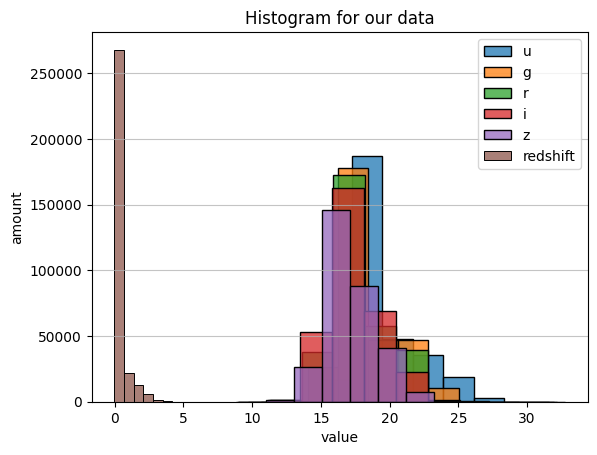

In [7]:
ranges={
"u": (-2000,50),
"g": (-2000,50),
"r": (0,50),
"z": (-2000,50),
}
for column, (min_val, max_val) in ranges.items():
    df = df[(df[column] >= min_val) & (df[column] <= max_val)]
    dr17 = dr17[(dr17[column] >= min_val) & (dr17[column] <= max_val)]

plt.figure()  # Create a new figure for each histogram
for column in df.select_dtypes(include=['number']).columns: 
    if column != 'ra'and column!='dec' and column != 'class':
        sns.histplot(data=df,x=column,label=column,multiple='stack', kde=False, bins=10)  # Histogram with KDE
plt.title(f'Histogram for our data')
plt.legend()
plt.xlabel('value')
plt.ylabel('amount')
plt.grid(axis='y', alpha=0.75)
plt.show()

Widzimy, że pozbyliśmy się wątpliwych danych.

In [8]:
df.describe()

,ra,dec,u,g,r,i,z,redshift
count,309996.000000,309996.000000,309996.000000,309996.000000,309996.000000,309996.000000,309996.000000,309996.000000
mean,174.694159,22.098265,19.748922,18.446126,17.771000,17.414858,17.204408,0.300034
std,85.594204,22.738541,2.165881,2.064533,1.907464,1.816122,1.807729,0.579809
min,0.003092,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,-0.009971
25%,131.354037,1.042524,18.510617,17.143940,16.472307,16.136682,15.908660,0.000107
50%,175.862814,17.145943,19.184505,17.904820,17.357665,17.063675,16.893280,0.070177
75%,223.633481,41.176999,20.162743,19.213590,18.882213,18.631763,18.436155,0.279417
max,359.999810,84.490494,32.781390,31.602240,31.990100,32.141470,29.383740,7.011245


Podzielmy dane na dwa oddzielne zestawy (przy się nam to potem):

In [9]:
y=df['class']
x=df.loc[:, df.columns != 'class']

Przyjrzyjmy się jak rozkładają się nasze dane dotyczące różnego typu obiektów.

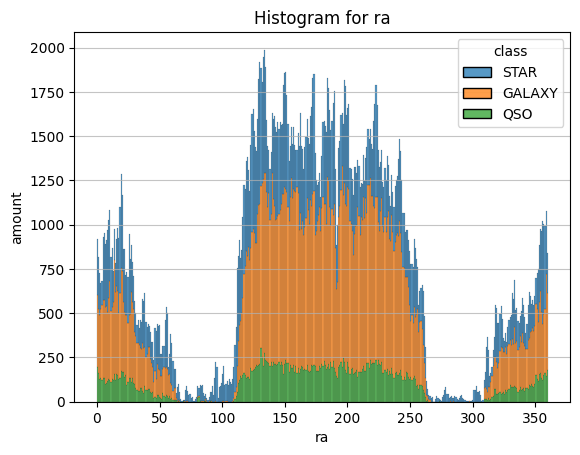

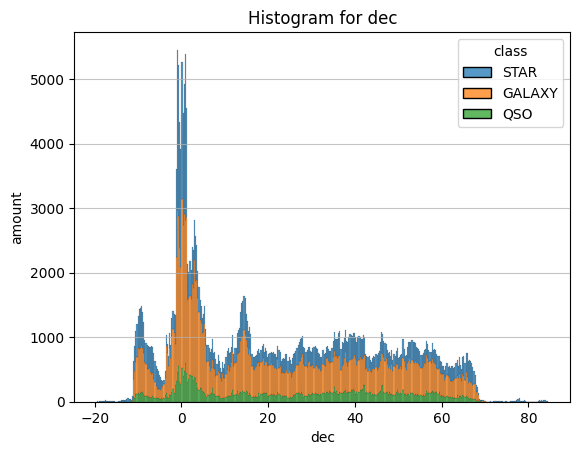

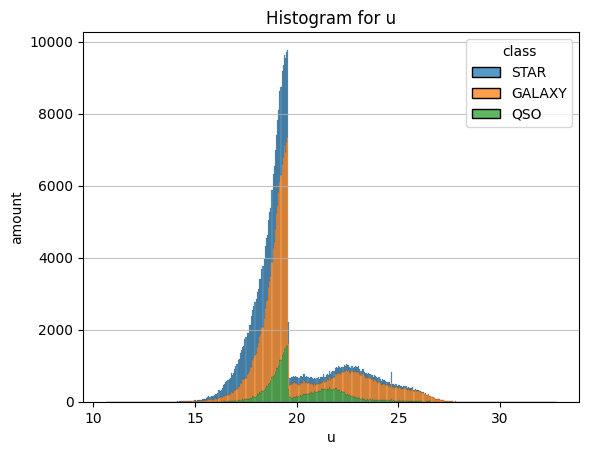

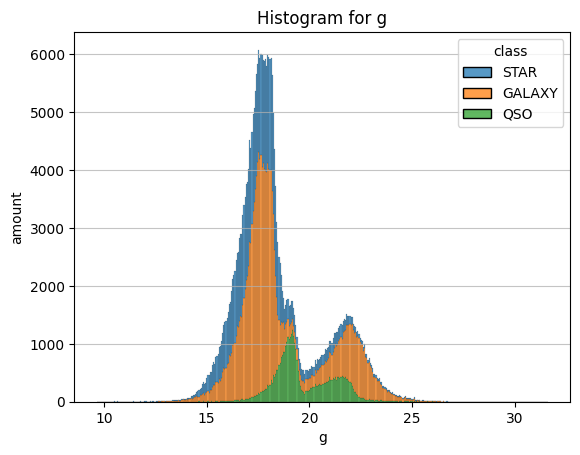

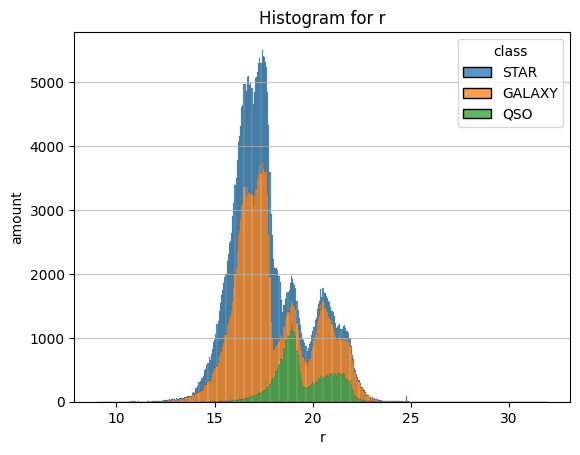

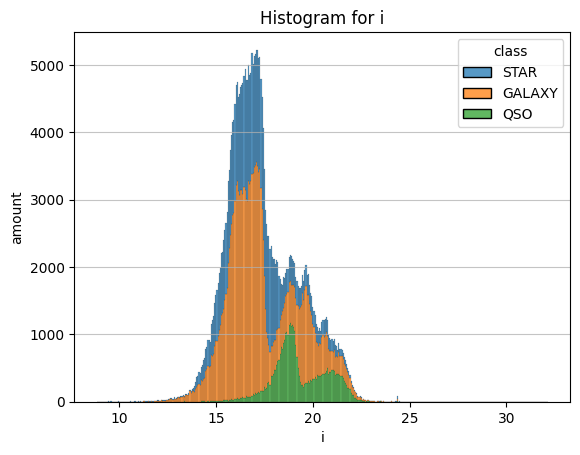

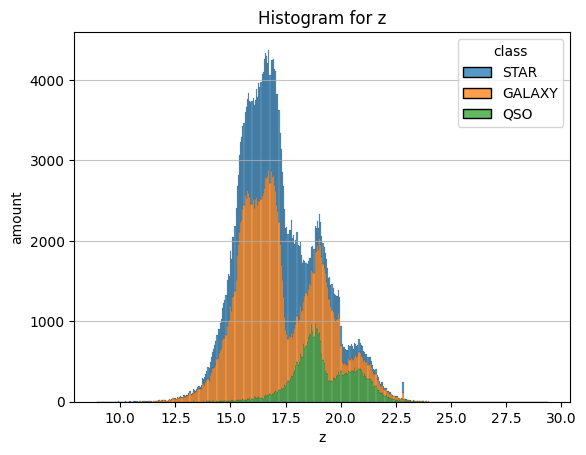

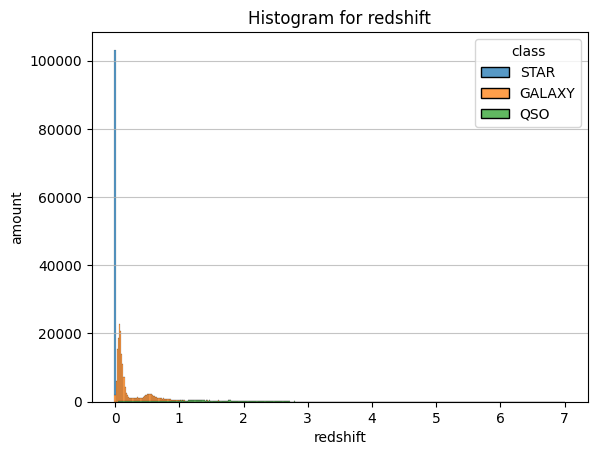

In [10]:
for column in df.select_dtypes(include=['number']).columns:  # Ensure numerical data
    plt.figure()  # Create a new figure for each histogram
    sns.histplot(data=df,x=column, hue='class',multiple='stack',bins=400, color='blue')  # Histogram with KDE
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('amount')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Zauważyć możemy ogromną dysproporcję w przesunięciu ku czerwieni - praktycznie wszystkie zarejestrowane gwiazdy mają niezwykle niską wartość. Ograniczmy oś Y.

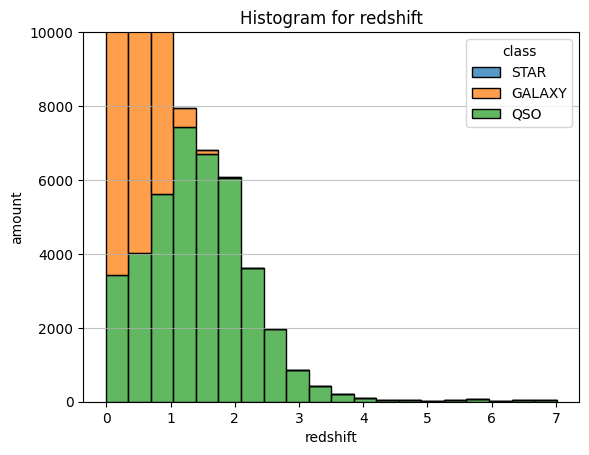

In [11]:
plt.figure()  # Create a new figure for each histogram
sns.histplot(data=df,x='redshift', hue='class',multiple='stack',bins=20, color='blue')  # Histogram with KDE
plt.title(f'Histogram for redshift')
plt.xlabel('redshift')
plt.ylabel('amount')
plt.ylim(0,10000)
plt.grid(axis='y', alpha=0.75)
plt.show()

Wraz ze zwiększającą się wartością przesunięcia ku czerwieni obserwowane są jedynie coraz to jaśniejsze obiekty. Jest to spodziewane - generalnie obiekty znajdujące się dalej powinny mieć wyższe wartości przesunięcia ku czerwieni (dla zainteresowanych: Prawo Hubble’a-Lemaître’a), także normalnym jest, że mniej jasne obiekty są mniej zauważalne.


Przyjrzyjmy się teraz nagłemu spadkowi w ilości obiektów w pobliżu obserwowanemu dla różnych spektrum światła. Hipoteza jest taka, że w którejś z naszych zestawów danych obserwacje nie osiągają wyższych wartości i spadek ten jest sztuczny.

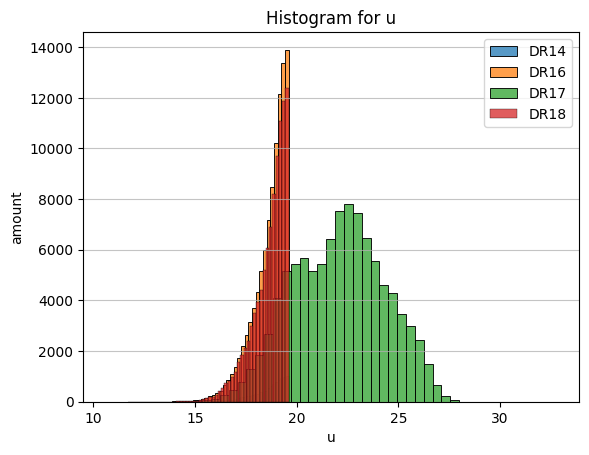

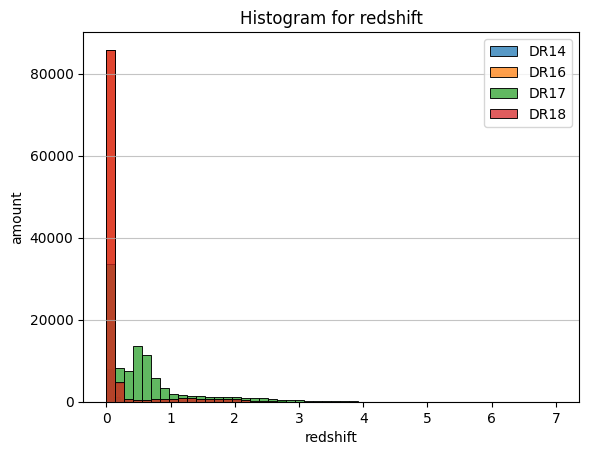

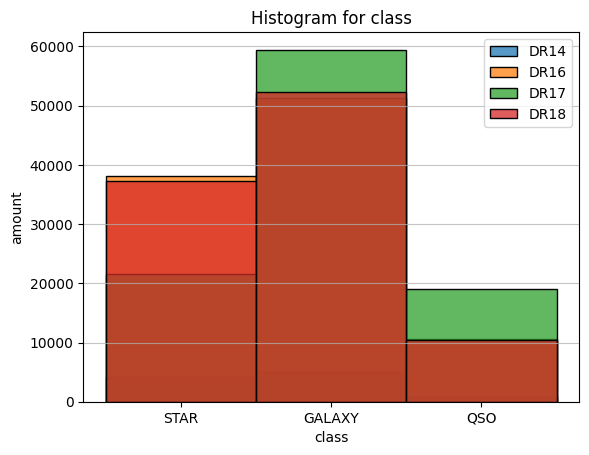

In [12]:
datasets = [dr14,dr16,dr17,dr18]
datasets_names = ["DR14", "DR16", "DR17","DR18"]
list_of_checks = ['u', 'redshift','class']
for what in list_of_checks:
    plt.figure()  # Create a new figure for each histogram
    for i,data in enumerate(datasets):
        sns.histplot(data=data,x=what,label=datasets_names[i],multiple='stack',bins=50)  # Histogram with KDE, hue='class',multiple='stack',bins=100
    plt.title(f'Histogram for {what}')
    plt.legend()
    plt.xlabel(what)
    plt.ylabel('amount')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    


Zauważyć możemy, żę DR17 zawiera znacząco mniej gwiazd oraz więcej galaktyk oraz QSO. Jest prawdopodne, że obiekty te są dużo bledsze niż te w pozostałych zestawach. Porównajmy je dla wartości 'u'

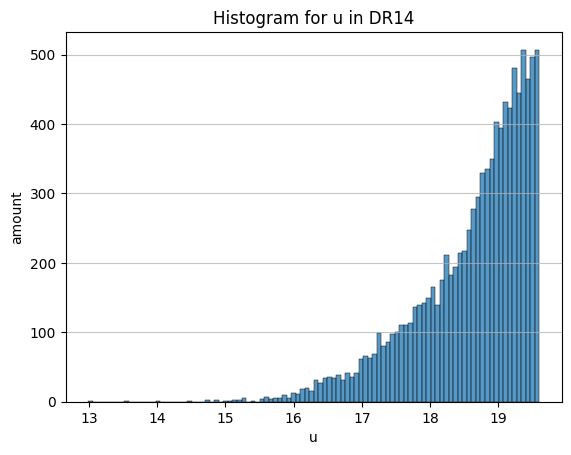

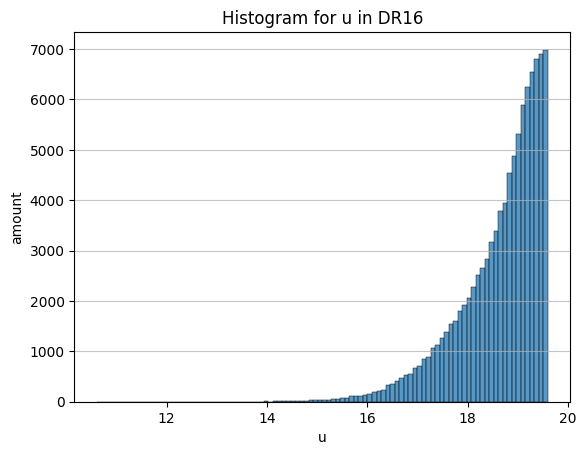

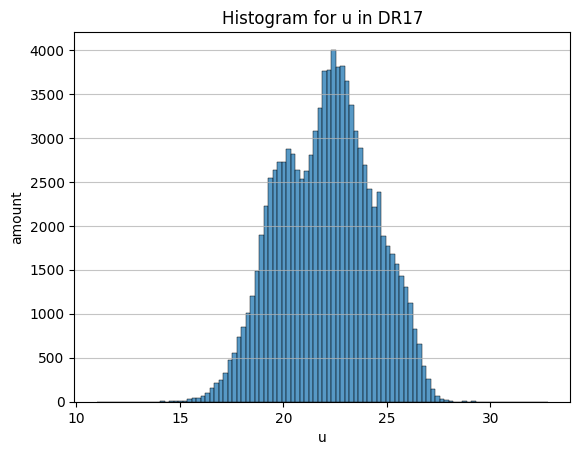

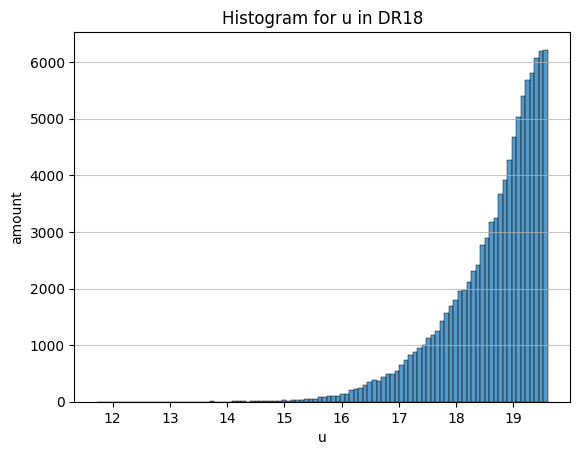

In [13]:
plt.figure()  # Create a new figure for each histogram
for i,data in enumerate(datasets):
    sns.histplot(data=data,x='u',bins=100)  # Histogram with KDE, hue='class',multiple='stack',bins=100
    plt.title(f'Histogram for u in {datasets_names[i]}')
    plt.xlabel('u')
    plt.ylabel('amount')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Widzimy, że dane z DR17 są przesunięte - obserwowane są obiekty dużo bledsze. 

In [14]:
uniques = pd.unique(df['class'])
binary_map = {}
for number, value in enumerate(uniques):
    binary_map[value] = number
df_mapped=df['class'].replace(binary_map)
binary_map

/tmp/ipykernel_24246/4074352913.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped=df['class'].replace(binary_map)


{'STAR': 0, 'GALAXY': 1, 'QSO': 2}

Zaprezentujmy macierz korelacji - wskaże ona, że położenie na niebie ma w naszym przypadku niewielkie znacznie w kwestii determinowania z jakim typem obiektu mamy doczynienia.

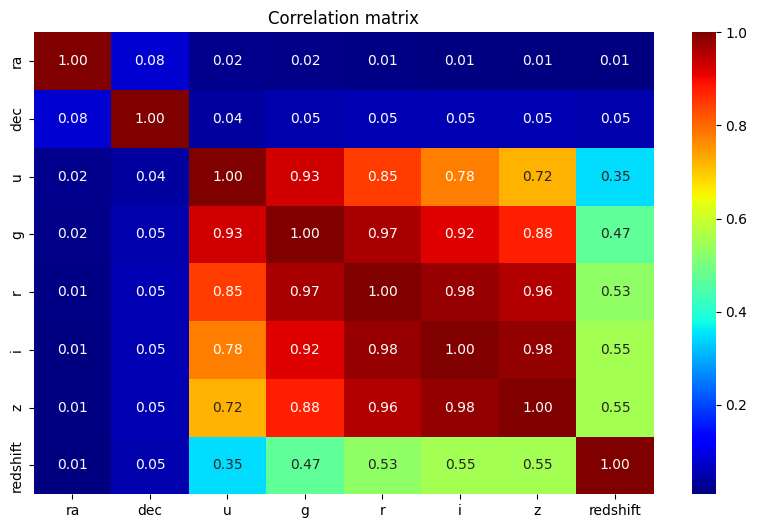

In [15]:
plt.figure(figsize=(10,6))
correlation = pd.concat([x,y],axis=1)
sns.heatmap(x.corr(), annot=True,cmap='jet',fmt='.2f') #jet,copper, coolwarm
plt.title('Correlation matrix')
plt.show()

Na wszelki wypadek sprawdzimy też macierz korelacji tylko dla DR17.

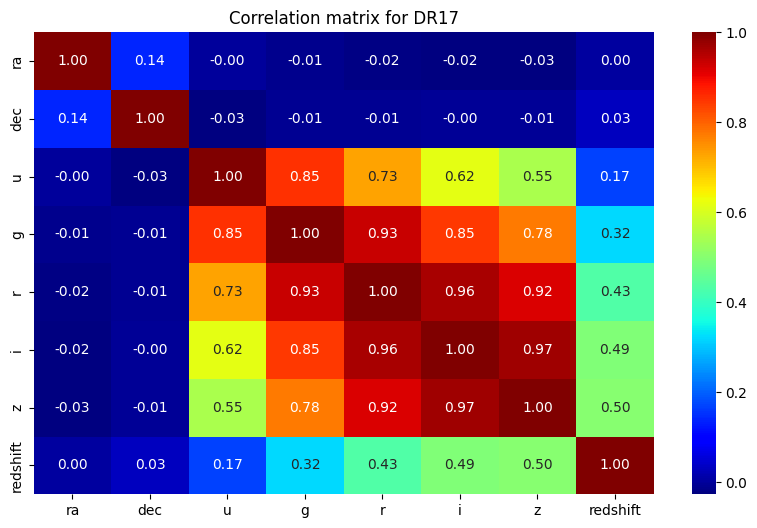

In [16]:
y_DR17=dr17['class']
x_DR17=dr17.drop(columns=['objid','run','rerun','camcol','field','specobjid','plate','mjd','fiberid',"class"])
plt.figure(figsize=(10,6))
correlation = pd.concat([x_DR17,y_DR17],axis=1)
sns.heatmap(x_DR17.corr(), annot=True,cmap='jet',fmt='.2f') #jet,copper, coolwarm
plt.title('Correlation matrix for DR17')
plt.show()

Możemy jednak wykorzystać dane o deklinacji i rektastencji do czegoś ciekawego - wizualizacji w 3D. W tym celu określi musimy odległość od obiektu. Posłużymy się do tego wartością przesunięcia ku czerwieni. Na jego podstawie oszacujemy prędkość:


A następnie odległość:
\begin{align}
D \approx \frac{redshift * c}{H_0}
\end{align}

In [17]:
import numpy as np

c=299792.458  #km/s
H0=71  # km/s / Mpc
distance= df["redshift"]*c/H0 #in Mpc
x=np.sin(df["ra"])*distance
y= np.cos(df["ra"])*distance
z =np.sin(df["dec"])*distance
light_sum = -df["u"]-df["g"]-df["r"]-df["i"]-df["z"]
size = (light_sum - np.min(light_sum))/(np.max(light_sum)-np.min(light_sum))
dictionary={"X [Mpc]":x, "Y [Mpc]":y,"Z [Mpc]":z,"class":df["class"],"size":size}
coordinates=pd.DataFrame(dictionary)

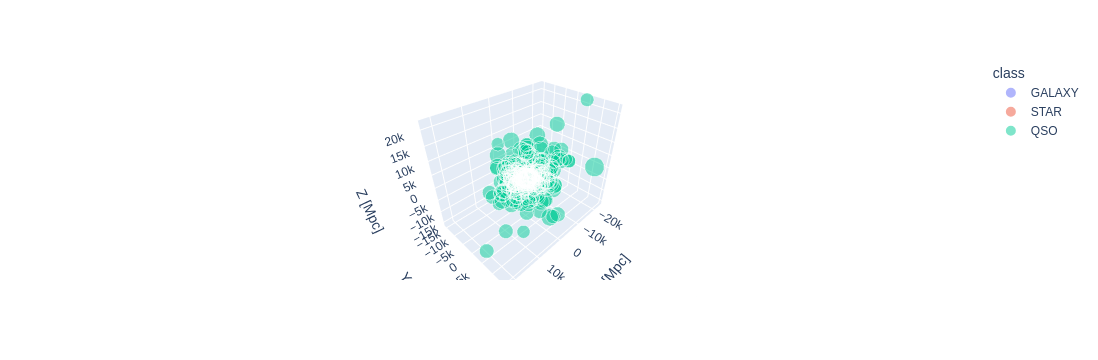

In [42]:
import plotly.express as px
coordinates_sample=coordinates.sample(2000, random_state=42)
fig = px.scatter_3d(coordinates_sample, x='X [Mpc]', y='Y [Mpc]', z='Z [Mpc]',
              color='class',size='size',opacity =0.5)
fig.show()

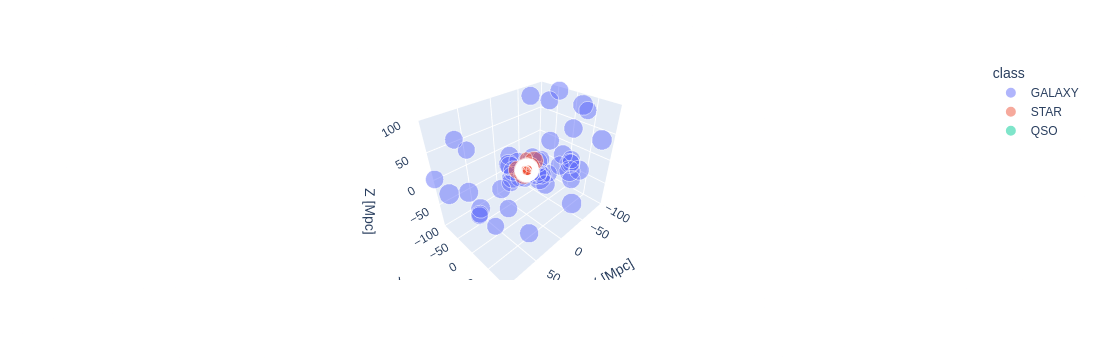

In [43]:
fig = px.scatter_3d(coordinates_sample, x='X [Mpc]', y='Y [Mpc]', z='Z [Mpc]',
              color='class',size='size',opacity =0.5)
fig.update_layout(scene=dict(
  xaxis = dict(range=[-100,100]),
 yaxis = dict(range=[-100,100]),
 zaxis = dict(range=[-100,100])
))

fig.show()